In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
import pandas as pd
import seaborn as sns
from easydict import EasyDict as edict
from utilities_norm import gen_post_full, gen_post_jef, getNPPcon, getLCPcon, getUIPJScon, getUIPDcon
from scipy.stats import norm

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from tqdm import tqdm
from collections import defaultdict as ddict
from pprint import pprint

In [296]:
theta0 = 1
sigma0 = sigma1 = sigma2 = 1
n = 100
thetas = [-0.5, 1]
ns = [80, 120]

In [217]:
def Ajsample(D, fixm, fixstd):
    sm = np.mean(D)
    sstd = np.std(D)
    return fixstd*(D-sm)/sstd + fixm 

In [218]:
D = norm.rvs(loc=theta0, scale=sigma0, size=n)
D = Ajsample(D, theta0, sigma0)
Ds = [ Ajsample(norm.rvs(loc=thetas[i], scale=sigma1, size=ns[i]), thetas[i], sigma1) for i in range(len(ns))] 

### MPP

In [201]:
NPP_model = getNPPcon(D, Ds)
with NPP_model:
    step = pm.Metropolis()
    post_normal_NPP = pm.sample(draws=5000, tune=5000, cores=4, chains=4, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [thetah]
>Metropolis: [sigma2]
>Metropolis: [gammas]
Sampling 4 chains, 0 divergences: 100%|██████████| 40000/40000 [00:02<00:00, 14578.29draws/s]
The number of effective samples is smaller than 10% for some parameters.


### LCP

In [202]:
LCP_model = getLCPcon(D, Ds)
with LCP_model:
    step = pm.Metropolis()
    #post_normal_LCP = pm.sample(draws=5000, tune=30000, cores=4, chains=4)
    post_normal_LCP = pm.sample(draws=5000, tune=20000, cores=4, chains=4, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [thetah]
>Metropolis: [sigma2]
>Metropolis: [logtaus]
Sampling 4 chains, 0 divergences: 100%|██████████| 100000/100000 [00:06<00:00, 14758.74draws/s]
The number of effective samples is smaller than 10% for some parameters.


### UIP

In [203]:
UIPD_model = getUIPDcon(D, Ds)
with UIPD_model:
    step = pm.Metropolis()
    post_normal_UIPD = pm.sample(draws=5000,tune=5000, cores=4, chains=4,step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [thetah]
>Metropolis: [M]
>Metropolis: [sigma2]
>Metropolis: [pis]
Sampling 4 chains, 0 divergences: 100%|██████████| 40000/40000 [00:04<00:00, 8202.98draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [204]:
res = getUIPJScon(D, Ds, diag=True)
UIPJS_model = res["UIPJS"]
pisJS = res["pis"]
with UIPJS_model:
    step = pm.Metropolis()
    post_normal_UIPJS = pm.sample(draws=5000, tune=5000,  cores=4, chains=4, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [thetah]
>Metropolis: [M]
>Metropolis: [sigma2]
Sampling 4 chains, 0 divergences: 100%|██████████| 40000/40000 [00:02<00:00, 15127.20draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [264]:
saveDir = Path("./")
saveName = f"prior_post_theta{theta0}_sigma{sigma0}.pkl"

In [230]:
saveData = {}
saveData["UIPD"] = post_normal_UIPD
saveData["UIPJS"] = [post_normal_UIPJS, pisJS]
saveData["MPP"] = post_normal_NPP
saveData["LCP"] = post_normal_LCP
saveData["D"] = D
saveData["Ds"] = Ds
saveData["ns"] = ns
with open(saveDir/saveName, "wb") as f:
    pickle.dump(saveData, f)

In [346]:
theta0 = 1
sigma0 = sigma1 = sigma2 = 1
n = 100
thetas = [-0.5, 1]
ns = [80, 120]

saveDir = Path("./")
saveName = f"prior_post_theta{theta0}_sigma{sigma0}.pkl"
with open(saveDir/saveName, "rb") as f:
    res = pickle.load(f)
post_normal_LCP = res["LCP"]
post_normal_NPP = res["MPP"]
post_normal_UIPD = res["UIPD"]
post_normal_UIPJS, pisJS = res["UIPJS"]
D = res["D"]
Ds = res["Ds"]
ns = res["ns"]

In [347]:
def getMPP(rs, ns, Ds):
    MLEs = [np.mean(Dh) for Dh in Ds]
    sVars = [np.var(Dh) for Dh in Ds]
    mWs = [rs[i]*ns[i]/sVars[i] for i in range(len(ns))]
    nmWs = np.array(mWs)/np.sum(mWs)
    pWs = [rs[i]*ns[i] for i in range(len(ns))]
    mean = np.sum([nmWs[i]*MLEs[i] for i in range(len(ns))])
    var = 1/np.sum([pWs[i]/sVars[i] for i in range(len(ns))])
    return {"mean": mean, "var":var}

In [348]:
def getLCP(taus, ns, Ds):
    MLEs = [np.mean(Dh) for Dh in Ds]
    sVars = [np.var(Dh) for Dh in Ds]
    mWs = [taus[i]*ns[i]/(sVars[i]*taus[i] + ns[i] ) for i in range(len(ns))]
    nmWs = np.array(mWs)/np.sum(mWs)
    pWs = [sVars[i]/(sVars[i]/ns[i]+1/taus[i]) for i in range(len(ns))]
    mean = np.sum([nmWs[i]*MLEs[i] for i in range(len(ns))])
    var = 1/np.sum([pWs[i]/sVars[i] for i in range(len(ns))])
    return {"mean": mean, "var":var}

In [349]:
def getUIP(ws, M, ns, Ds):
    MLEs = [np.mean(Dh) for Dh in Ds]
    sVars = [np.var(Dh) for Dh in Ds]
    pWs = np.array(ws)*M
    mean = np.sum([wk*MLEk for wk, MLEk in zip(ws, MLEs)])
    var = 1/np.sum([pWsk /sVarsk for pWsk, sVarsk in zip(pWs, sVars)])
    return {"mean": mean, "var":var}

In [350]:
logtaus = np.mean(post_normal_LCP["logtaus"], axis=0)
taus = np.exp(logtaus)
rs = np.mean(post_normal_NPP["gammas"], axis=0)
ws = np.mean(post_normal_UIPD["pis"], axis=0)
M = np.mean(post_normal_UIPD["M"])
#wsJS = np.mean(post_normal_UIPD["pis"], axis=0)
MJS = np.mean(post_normal_UIPJS["M"])

In [351]:
MPPpost = post_normal_NPP["thetah"]
LCPpost = post_normal_LCP["thetah"]
UIPDpost = post_normal_UIPD["thetah"]
UIPJSpost = post_normal_UIPJS["thetah"]

In [352]:
MPPparas = getMPP(rs, ns, Ds)
LCPparas = getLCP(taus, ns, Ds)
UIPparas = getUIP(ws, M, ns, Ds)
UIPJSparas = getUIP(pisJS, MJS, ns, Ds)

In [353]:
MPPnorm = norm(loc=MPPparas["mean"], scale=np.sqrt(MPPparas["var"]))
LCPnorm = norm(loc=LCPparas["mean"], scale=np.sqrt(LCPparas["var"]))
UIPnorm = norm(loc=UIPparas["mean"], scale=np.sqrt(UIPparas["var"]))
UIPJSnorm = norm(loc=UIPJSparas["mean"], scale=np.sqrt(UIPJSparas["var"]))

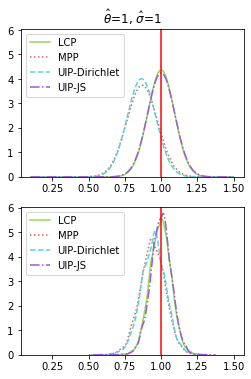

In [363]:
colors = sns.color_palette("hls", 4)
x = np.linspace(0.1, 1.5, 1000)
#x = np.linspace(-1.55, 0.5, 1000)
#x = np.linspace(-1, 0.5, 1000)

tl = r"$\hat{\theta}$" + f"={theta0}" + ", " +  r"$\hat{\sigma}$" + f"={sigma0}"
fig = plt.figure(figsize=(4, 6))
ax1 = plt.subplot(211)
plt.title(tl)
plt.plot(x, LCPnorm.pdf(x), label="LCP", linestyle="-", color=colors[1])
plt.plot(x, MPPnorm.pdf(x), label="MPP", linestyle=":", color=colors[0])
plt.plot(x, UIPnorm.pdf(x), label="UIP-Dirichlet", linestyle="--", color=colors[2])
plt.plot(x, UIPJSnorm.pdf(x), label="UIP-JS", linestyle="-.", color=colors[3])
plt.axvline(theta0, color="red")
plt.legend()

plt.subplot(212, sharex=ax1, sharey=ax1)
sns.kdeplot(LCPpost, color=colors[1], label="LCP", linestyle="-")
sns.kdeplot(MPPpost, color=colors[0], label="MPP", linestyle=":")
sns.kdeplot(UIPDpost, color=colors[2], label="UIP-Dirichlet", linestyle="--")
sns.kdeplot(UIPJSpost, color=colors[3], label="UIP-JS", linestyle="-.")
plt.axvline(theta0, color="red")
plt.savefig(f"prior_post_theta{theta0}_sigma{sigma0}.pdf")
plt.legend()

In [295]:
taus

array([9.08033603e+02, 1.58225439e-01])